# Prophet(Facebook) and [NeuralProphet](https://github.com/ourownstory/neural_prophet) Comparison
By: Jhonnatan Torres

The goal of this notebook is to compare the *expected values* forecasted by these two models and compare them against the actuals in order to calculate the performance metrics and define which model performs better using this time series dataset (Covid19 Confirmed Cases for Colombia)
___ 

Importing basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(1234)

In [3]:
plt.style.use('ggplot')

Reading the time series

In [4]:
ts = pd.read_csv('https://raw.githubusercontent.com/JOTOR/Datasets/main/Colombia_CovidV2.csv', parse_dates=True)

In [5]:
ts.head()

,item_id,timestamp,target_value
0,1,2020-03-06,1
1,1,2020-03-10,2
2,1,2020-03-11,6
3,1,2020-03-13,4
4,1,2020-03-14,9


This is the data format required by AWS Forecast, in order to use this time series with Prophet some changes are required, the first column should be removed and the names of the remaining columns should be changed

In [6]:
ts.drop(columns='item_id', inplace=True)
ts.rename(columns={'timestamp':'ds','target_value':'y'},inplace=True)

In [7]:
ts.head()

,ds,y
0,2020-03-06,1
1,2020-03-10,2
2,2020-03-11,6
3,2020-03-13,4
4,2020-03-14,9


In [8]:
ts.tail()

,ds,y
444,2021-05-28,23374
445,2021-05-29,20494
446,2021-05-30,20218
447,2021-05-31,23177
448,2021-06-01,25966


Text(0.5, 1.0, 'Time Series Plot')

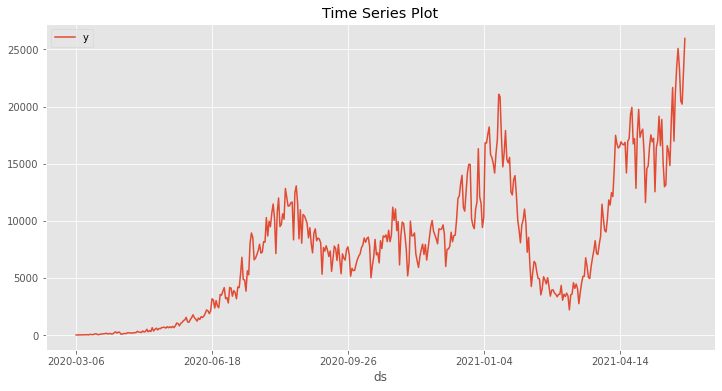

In [9]:
ts.set_index('ds').plot(figsize=(12,6))
plt.title('Time Series Plot')

## Prophet Model

In [10]:
!pip install prophet -q

In [11]:
from prophet import Prophet

In [12]:
m = Prophet(seasonality_mode='multiplicative').add_country_holidays(country_name='CO')

*   Holidays for Colombia were included, this is a time series specific for this country
*   Using default settings, only the seasonality mode is set to *Multiplicative*



In [13]:
m.fit(ts)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = m.make_future_dataframe(periods=30, freq='D')

In [15]:
future.tail(5)

,ds
474,2021-06-27
475,2021-06-28
476,2021-06-29
477,2021-06-30
478,2021-07-01


In [16]:
forecast = m.predict(future)

In [17]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Ascensión del señor [Ascension of Jesus](Observed),Ascensión del señor [Ascension of Jesus](Observed)_lower,Ascensión del señor [Ascension of Jesus](Observed)_upper,Año Nuevo [New Year's Day],Año Nuevo [New Year's Day]_lower,Año Nuevo [New Year's Day]_upper,Batalla de Boyacá [Battle of Boyacá],Batalla de Boyacá [Battle of Boyacá]_lower,Batalla de Boyacá [Battle of Boyacá]_upper,Corpus Christi [Corpus Christi](Observed),Corpus Christi [Corpus Christi](Observed)_lower,Corpus Christi [Corpus Christi](Observed)_upper,Descubrimiento de América [Discovery of America],Descubrimiento de América [Discovery of America]_lower,Descubrimiento de América [Discovery of America]_upper,Descubrimiento de América [Discovery of America](Observed),Descubrimiento de América [Discovery of America](Observed)_lower,Descubrimiento de América [Discovery of America](Observed)_upper,Dia de Todos los Santos [All Saint's Day],Dia de Todos los Santos [All Saint's Day]_lower,Dia de Todos los Santos [All Saint's Day]_upper,Dia de Todos los Santos [All Saint's Day](Observed),Dia de Todos los Santos [All Saint's Day](Observed)_lower,Dia de Todos los Santos [All Saint's Day](Observed)_upper,Día de San José [Saint Joseph's Day](Observed),Día de San José [Saint Joseph's Day](Observed)_lower,Día de San José [Saint Joseph's Day](Observed)_upper,Día de la Independencia [Independence Day],Día de la Independencia [Independence Day]_lower,Día de la Independencia [Independence Day]_upper,Día de los Reyes Magos [Epiphany],Día de los Reyes Magos [Epiphany]_lower,Día de los Reyes Magos [Epiphany]_upper,Día de los Reyes Magos [Epiphany](Observed),...,Independencia de Cartagena [Independence of Cartagena](Observed),Independencia de Cartagena [Independence of Cartagena](Observed)_lower,Independencia de Cartagena [Independence of Cartagena](Observed)_upper,Jueves Santo [Maundy Thursday],Jueves Santo [Maundy Thursday]_lower,Jueves Santo [Maundy Thursday]_upper,La Asunción [Assumption of Mary](Observed),La Asunción [Assumption of Mary](Observed)_lower,La Asunción [Assumption of Mary](Observed)_upper,La Inmaculada Concepción [Immaculate Conception],La Inmaculada Concepción [Immaculate Conception]_lower,La Inmaculada Concepción [Immaculate Conception]_upper,Navidad [Christmas],Navidad [Christmas]_lower,Navidad [Christmas]_upper,Sagrado Corazón [Sacred Heart](Observed),Sagrado Corazón [Sacred Heart](Observed)_lower,Sagrado Corazón [Sacred Heart](Observed)_upper,San Pedro y San Pablo [Saint Peter and Saint Paul],San Pedro y San Pablo [Saint Peter and Saint Paul]_lower,San Pedro y San Pablo [Saint Peter and Saint Paul]_upper,San Pedro y San Pablo [Saint Peter and Saint Paul](Observed),San Pedro y San Pablo [Saint Peter and Saint Paul](Observed)_lower,San Pedro y San Pablo [Saint Peter and Saint Paul](Observed)_upper,Viernes Santo [Good Friday],Viernes Santo [Good Friday]_lower,Viernes Santo [Good Friday]_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
474,2021-06-27,21402.479039,16962.065228,24895.580078,21218.856332,21589.311310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.021814,-0.021814,-0.021814,-0.021814,-0.021814,-0.021814,0.0,0.0,0.0,20935.614154
475,2021-06-28,21510.372601,15187.737321,22534.404154,21313.941885,21710.077765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.127397,-0.127397,-0.127397,-0.127397,-0.127397,-0.127397,0.0,0.

Text(0.5, 1.0, 'Forecast of the Time Series in the next 30 days')

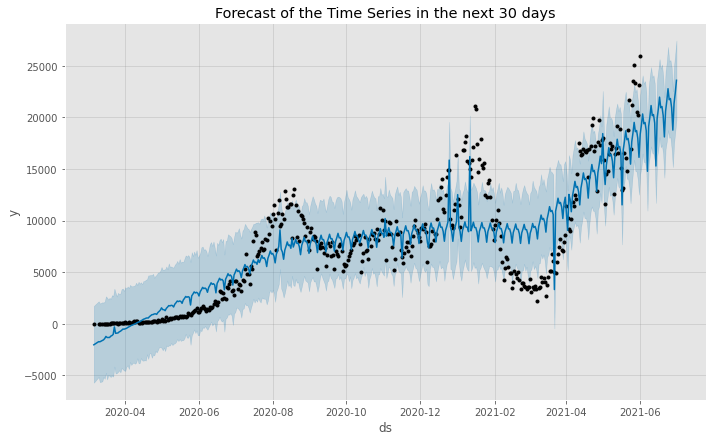

In [18]:
m.plot(forecast);
plt.title("Forecast of the Time Series in the next 30 days")

Components of the time series:


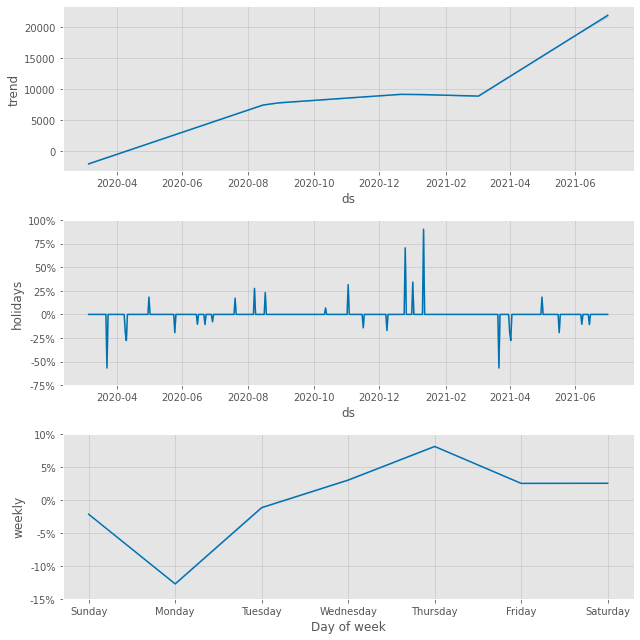

In [19]:
m.plot_components(forecast);
print("Components of the time series:")

In [20]:
detail = forecast[forecast['ds']>'2021-06-01'][['ds','yhat_lower','yhat','yhat_upper']]

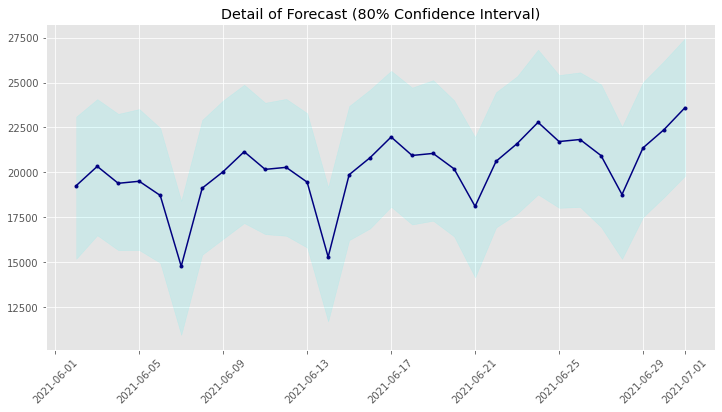

In [21]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
plt.title("Detail of Forecast (80% Confidence Interval)")
plt.plot(detail['ds'], detail['yhat'], marker='.', c='navy')
plt.fill_between(detail['ds'],detail['yhat_lower'], detail['yhat_upper'], alpha=0.1, color='cyan')

### Getting the actuals

In [22]:
act = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [23]:
act.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,11/2/21,11/3/21,11/4/21,11/5/21,11/6/21,11/7/21,11/8/21,11/9/21,11/10/21,11/11/21,11/12/21,11/13/21,11/14/21,11/15/21,11/16/21,11/17/21,11/18/21,11/19/21,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21,11/30/21,12/1/21,12/2/21,12/3/21,12/4/21,12/5/21,12/6/21,12/7/21,12/8/21,12/9/21,12/10/21,12/11/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,156307,156323,156363,156392,156397,156397,156397,156397,156414,156456,156487,156510,156552,156610,156649,156739,156739,156812,156864,156896,156911,157015,157032,157144,157171,157190,157218,157260,157289,157359,157387,157412,157431,157445,157499,157508,157542,157585,157858,157858
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,186222,186793,187363,187994,187994,189125,189355,190125,190815,191440,192013,192600,193075,193269,193856,194472,195021,195523,195988,195988,196611,197167,197776,198292,198732,199137,199555,199750,199945,200173,200639,201045,201402,201730,201902,202295,202641,202863,203215,203524
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,206649,206754,206878,206995,207079,207156,207254,207385,207509,207624,207764,207873,207970,208104,208245,208380,208532,208695,208839,208952,209111,209283,209463,209624,209817,209980,210152,210344,210531,210723,210921,211112,211297,211469,211662,211859,212047,212224,212434,212652
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,15516,15572,15618,15618,15618,15618,15705,15717,15744,15744,15819,15819,15819,15907,15929,15972,16035,16086,16086,16086,16299,16342,16426,16566,16712,16712,16712,16712,17115,17426,17658,18010,18010,18010,18631,18815,18815,19272,19440,19440
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,64487,64533,64583,64612,64654,64674,64724,64762,64815,64857,64875,64899,64913,64913,64940,64968,64985,64997,65011,65024,65033,65061,65080,65105,65130,65139,65144,65155,65168,65183,65208,65223,65244,65259,65259,65301,65332,65346,65371,65397


In [24]:
act = act.loc[act['Country/Region']=='Colombia'].drop(columns=['Province/State', 'Lat', 'Long'])

In [25]:
act = pd.melt(act, id_vars='Country/Region', var_name='ds', value_name='y').drop(columns='Country/Region')

In [26]:
act['ds'] = pd.to_datetime(act['ds'])

In [27]:
act = act[lambda x: x.ds <= '2021-07-01']

In [28]:
act.tail()

,ds,y
522,2021-06-27,4158716
523,2021-06-28,4187194
524,2021-06-29,4213074
525,2021-06-30,4240982
526,2021-07-01,4269297


These are the cumulative numbers and the time series used in the model was the difference between the dates ( Date B - Date A )

In [29]:
#Calculating the difference
act = act.set_index('ds').diff().reset_index()

Text(0.5, 1.0, 'Time Series of Actual Values')

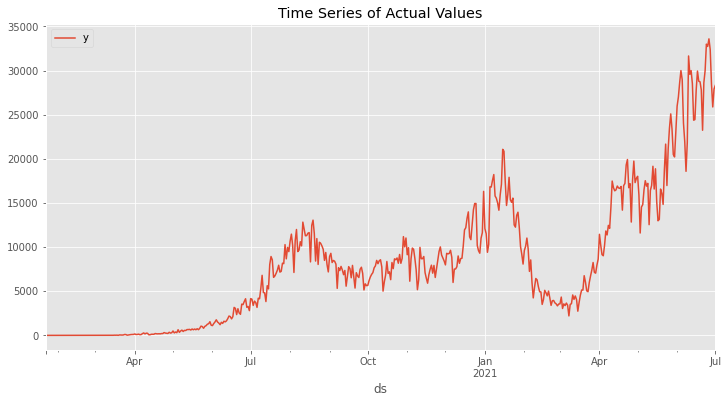

In [30]:
act.set_index('ds').plot(figsize=(12,6))
plt.title("Time Series of Actual Values")

In [31]:
act = act[(act['ds']>'2021-06-01') & (act['ds']<'2021-07-02')]

Text(0.5, 1.0, 'Detail of Actual Values')

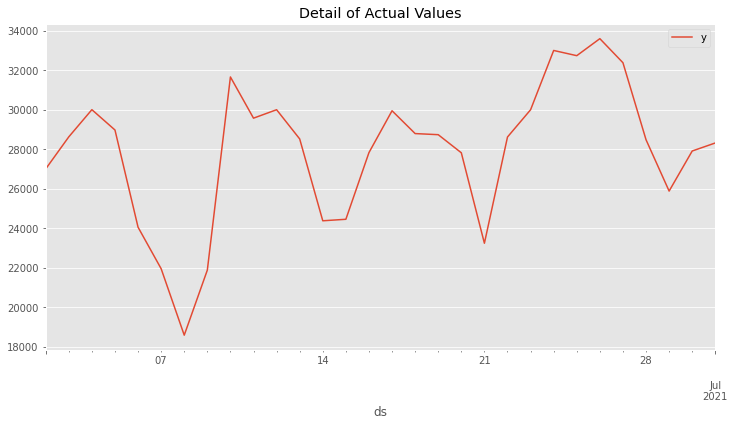

In [32]:
act.set_index('ds').plot(figsize=(12,6))
plt.title("Detail of Actual Values")

After all these transformations, these are the actual numbers for the days between June 2nd and July 1st

In [33]:
act.head()

,ds,y
497,2021-06-02,27000.0
498,2021-06-03,28624.0
499,2021-06-04,30000.0
500,2021-06-05,28971.0
501,2021-06-06,24050.0


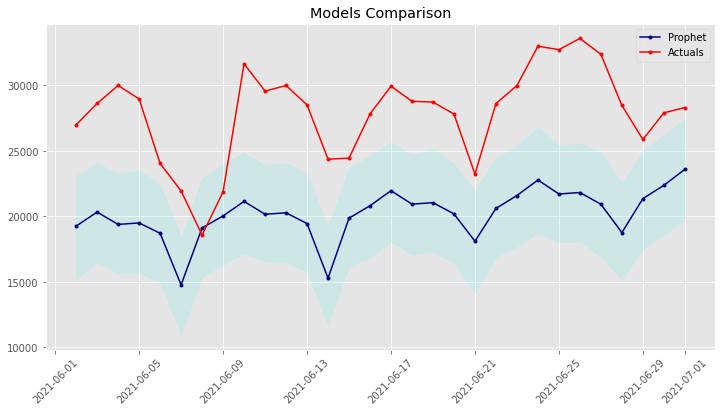

In [34]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
plt.title("Models Comparison")
plt.plot(detail['ds'], detail['yhat'], marker='.', c='navy', label='Prophet')
plt.fill_between(detail['ds'],detail['yhat_lower'], detail['yhat_upper'], alpha=0.1, color='cyan')
plt.plot(act['ds'], act['y'], c='red', label='Actuals', marker='.')
plt.legend()

### Performance Metrics

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [36]:
prophet_mae = mean_absolute_error(act['y'], detail['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(act['y'], detail['yhat']))

In [37]:
print("Prophet RMSE: {:.4f}".format(prophet_rmse))
print("Prophet MAE: {:.4f}".format(prophet_mae))

Prophet RMSE: 8179.9423
Prophet MAE: 7729.1117


## NeuralProphet

In [38]:
!pip install neuralprophet -q

In [39]:
from neuralprophet import NeuralProphet, set_random_seed

In [40]:
set_random_seed(42)

In [41]:
nm = NeuralProphet(seasonality_mode='multiplicative').add_country_holidays(country_name='CO')

In [42]:
nm.fit(ts, freq='D')

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 220
INFO:NP.config:Auto-set epochs to 220


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.86E-02, min: 7.21E-02
INFO:NP.utils_torch:lr-range-test results: steep: 3.86E-02, min: 7.21E-02


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.95E-02, min: 6.03E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.95E-02, min: 6.03E-02


  0%|          | 0/233 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.22E-02, min: 7.88E-02
INFO:NP.utils_torch:lr-range-test results: steep: 4.22E-02, min: 7.88E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.63E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 3.63E-02
Epoch[220/220]: 100%|██████████| 220/220 [00:11<00:00, 19.42it/s, SmoothL1Loss=0.00612, MAE=1.29e+3, RMSE=1.89e+3, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.058551,4743.531636,5907.281288,0.0
1,0.057574,4723.010990,5871.787072,0.0
2,0.056882,4708.443151,5790.297280,0.0
3,0.056121,4679.257419,5795.255661,0.0
4,0.055260,4646.949996,5706.001508,0.0
...,...,...,...,...
215,0.006120,1288.881138,1870.131716,0.0
216,0.006120,1288.866083,1893.418654,0.0
217,0.006118,1288.858786,1898.369119,0.0
218,0.006118,1288.884835,1865.053995,0.0


In [43]:
n_future = nm.make_future_dataframe(ts, periods=30)

In [44]:
n_future.tail()

,ds,y
25,2021-06-27,None
26,2021-06-28,None
27,2021-06-29,None
28,2021-06-30,None
29,2021-07-01,None


In [45]:
n_forecast = nm.predict(n_future)

In [46]:
n_forecast.tail()

,ds,y,yhat1,residual1,trend,season_weekly,events_additive,event_Ascensión del señor [Ascension of Jesus](Observed),event_Año Nuevo [New Year's Day],event_Batalla de Boyacá [Battle of Boyacá],event_Corpus Christi [Corpus Christi](Observed),event_Descubrimiento de América [Discovery of America],event_Descubrimiento de América [Discovery of America](Observed),event_Dia de Todos los Santos [All Saint's Day],event_Dia de Todos los Santos [All Saint's Day](Observed),event_Día de San José [Saint Joseph's Day](Observed),event_Día de la Independencia [Independence Day],event_Día de los Reyes Magos [Epiphany],event_Día de los Reyes Magos [Epiphany](Observed),event_Día del Trabajo [Labour Day],event_Independencia de Cartagena [Independence of Cartagena](Observed),event_Jueves Santo [Maundy Thursday],event_La Asunción [Assumption of Mary](Observed),event_La Inmaculada Concepción [Immaculate Conception],event_Navidad [Christmas],event_Sagrado Corazón [Sacred Heart](Observed),event_San Pedro y San Pablo [Saint Peter and Saint Paul],event_San Pedro y San Pablo [Saint Peter and Saint Paul](Observed),event_Viernes Santo [Good Friday]
25,2021-06-27,None,28570.138672,NaN,29315.476562,-0.025426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,2021-06-28,None,25399.898438,NaN,29553.908203,-0.140562,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,2021-06-29,None,29064.687500,NaN,29792.339844,-0.024425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,2021-06-30,None,31485.541016,NaN,30030.779297,0.048444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,2021-07-01,None,32394.085938,NaN,30269.218750,0.070201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


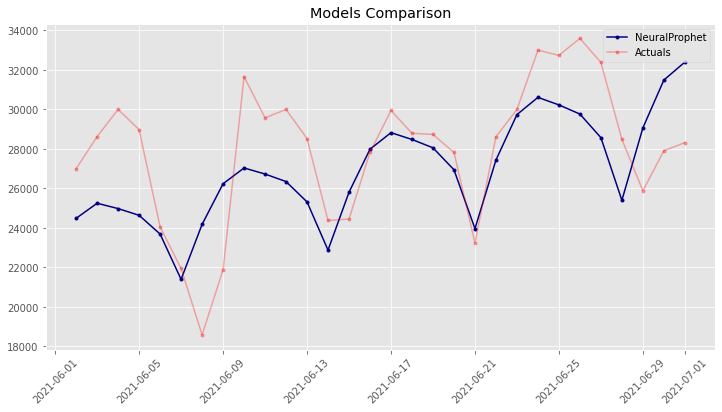

In [47]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
plt.title("Models Comparison")
plt.plot(n_forecast['ds'], n_forecast['yhat1'], marker='.', c='navy', label='NeuralProphet')
plt.plot(act['ds'], act['y'], c='red', label='Actuals', marker='.', alpha=0.3)
plt.legend()

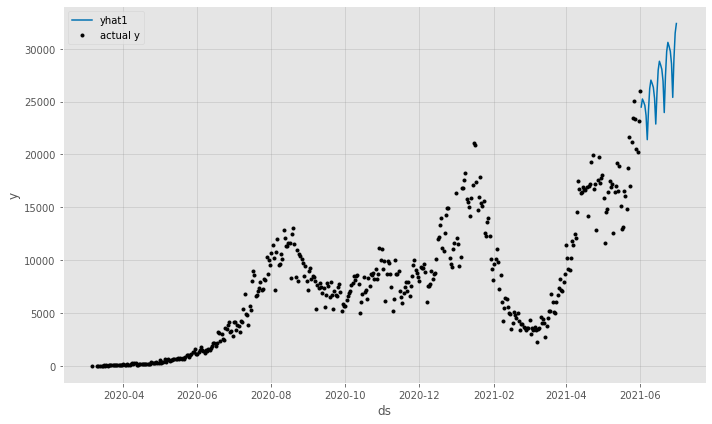

In [48]:
nm.plot(pd.concat([ts, n_forecast], ignore_index=True));

### Performance Metrics

In [49]:
n_prophet_mae = mean_absolute_error(act['y'], n_forecast['yhat1'])
n_prophet_rmse = np.sqrt(mean_squared_error(act['y'], n_forecast['yhat1']))

In [50]:
print("Neural Prophet RMSE: {:.4f}".format(n_prophet_rmse))
print("Neural Prophet MAE: {:.4f}".format(n_prophet_mae))

Neural Prophet RMSE: 2968.1009
Neural Prophet MAE: 2501.3087


In [51]:
print("Prophet RMSE: {:.4f}".format(prophet_rmse))
print("Prophet MAE: {:.4f}".format(prophet_mae))

Prophet RMSE: 8179.9423
Prophet MAE: 7729.1117


In [52]:
n_prophet_rmse - prophet_rmse

-5211.841382266553

## Final Comments

*   At least for this particular dataset and using the default arguments,  the **NeuralProphet** model scored a **RMSE** of **2968** whereas the **Prophet** model scored a **RMSE** of **8179**, a **5211 (~63.7%) difference** compared against the first model